In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from functools import partial
from tqdm import tqdm
from scipy.optimize import lsq_linear
from matplotlib import rc

In [102]:
rc('axes', linewidth=2)

In [266]:
%matplotlib qt

In [103]:
mip_dir = r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_03_07-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_modified_earlyL3_timeseries/larvae_2/mips'
df = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_03_07-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_modified_earlyL3_timeseries/larvae_2/manual_analysis/all_cells.pkl')

In [13]:
def assemble_green_mip_stack(mip_dir):
    shape = np.array(Image.open(mip_dir + '/mip_green_0.tif')).shape
    files = glob(mip_dir + '/*green*.tif')
    mips = np.zeros(((len(files),) + shape))
    for i in range(len(mips)):
        mips[i] = np.array(Image.open(mip_dir + f'/mip_green_{i}.tif'))
    
    return mips
    

def quantify_cells(df, mips, r):
    func = partial(quantify_cell, mips=mips, r=r)
    intens = df.apply(func, axis=1)
    df['dpt_gfp'] = intens
    
    return df

def quantify_cell(row, mips, r):
    y = int(row.y)
    x = int(row.x)
    t = int(row.t)
    #print(t)
    mask = disk(x, y, r, mips.shape[1:])
    inten = np.sum(mask * mips[t]) / np.sum(mask)
    
    return inten
    

def disk(x, y, r, shape):
    ygrid, xgrid = np.indices(shape)
    distances = np.sqrt((x - xgrid) ** 2 + (y - ygrid) ** 2)
    disk = distances <= r
    
    return disk




def fit_trace(inten, t_arr):
    if np.sum(inten==0) < len(inten):
        first_id = np.where(inten > 0)[0][0]
        inten = inten[first_id:]
        t_arr = t_arr[first_id:]
    slope, offset = fit_line(t_arr, inten)
    
    return slope, offset
    

def fit_line(x, y):
    mx = np.mean(x)
    my = np.mean(y)
    slope = np.sum((x - mx) * (y - my)) / np.sum((x - mx) ** 2)
    offset = my - slope * mx
    
    return slope, offset
    
    

In [11]:
mips = assemble_green_mip_stack(mip_dir)

In [131]:
df = quantify_cells(df, mips, r=20)

In [133]:
df.to_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_03_07-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_modified_earlyL3_timeseries/larvae_2/manual_analysis/all_cells.pkl')

In [46]:
np.max(df.dpt_gfp)

0.023412530812964034

In [51]:
%matplotlib qt

In [462]:
df = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_03_07-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_modified_earlyL3_timeseries/larvae_2/manual_analysis/all_cells.pkl')

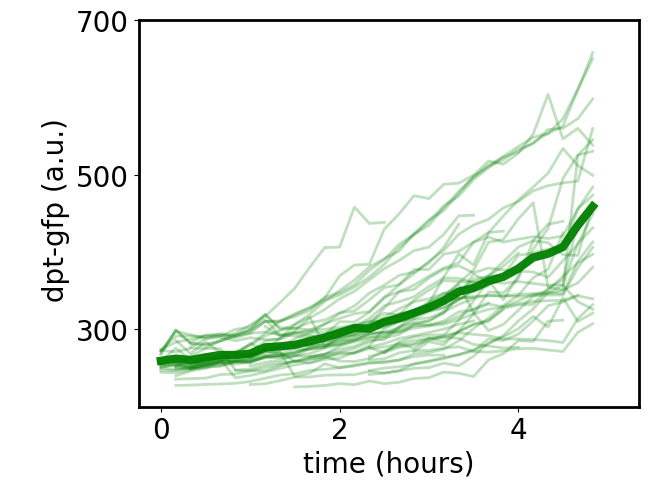

In [105]:
plt.figure()
fontsize = 20
cell_ids = np.unique(df.cell_id)
bkg = 0.01
for id in cell_ids:
    sub_df = df[df.cell_id==id]
    sub_df = sub_df.sort_values(by='t')
    inten = sub_df.dpt_gfp
    inten = inten - bkg
    inten[inten < 0] = 0
    plt.plot(sub_df.t / 6, inten, linewidth=2, alpha=0.25, color='g')
    #plt.plot(sub_df.t, sub_df.dpt_gfp)
mean = df.groupby('t').mean().dpt_gfp
plt.plot(np.unique(df.t) / 6, mean.values, linewidth=6, alpha=0.95, color='g')

plt.xlim([-0.25, 5.35])
plt.ylim([200, 700])
plt.xlabel('time (hours)', fontsize=fontsize)
plt.ylabel('\n dpt-gfp (a.u.)', fontsize=fontsize)
plt.xticks([0, 2, 4])
plt.yticks([300, 500, 700])
#plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/traces_and_mean_trace.pdf')


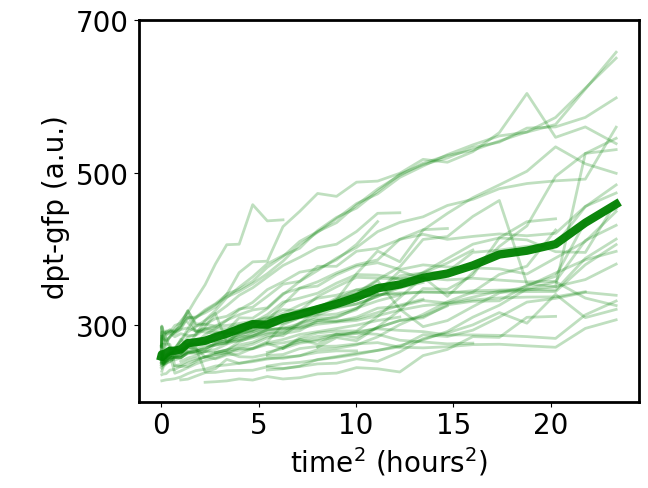

In [106]:
plt.figure()
fontsize = 20
cell_ids = np.unique(df.cell_id)
bkg = 0.01
for id in cell_ids:
    sub_df = df[df.cell_id==id]
    sub_df = sub_df.sort_values(by='t')
    inten = sub_df.dpt_gfp
    inten = inten - bkg
    inten[inten < 0] = 0
    plt.plot((sub_df.t / 6) ** 2, inten, linewidth=2, alpha=0.25, color='g')
    #plt.plot(sub_df.t, sub_df.dpt_gfp)
mean = df.groupby('t').mean().dpt_gfp
plt.plot((np.unique(df.t) / 6) ** 2, mean.values, linewidth=6, alpha=0.95, color='g')
#plt.plot((np.unique(df.t) / 6) ** 2, 4 * (np.unique(df.t) / 6) ** 2 + 200, linewidth=6, alpha=0.95, color='k')

#plt.xlim([-0.25, 5.35])
plt.ylim([200, 700])
plt.xlabel('time$^2$ (hours$^2$)', fontsize=fontsize)
plt.ylabel('\n dpt-gfp (a.u.)', fontsize=fontsize)
#plt.xticks([0, 2, 4])
plt.yticks([300, 500, 700])
#plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/traces_and_mean_trace_vs_t2.pdf')


/tmp/ipykernel_459265/974677170.py:52: RuntimeWarning: invalid value encountered in double_scalars
  slope = np.sum((x - mx) * (y - my)) / np.sum((x - mx) ** 2)


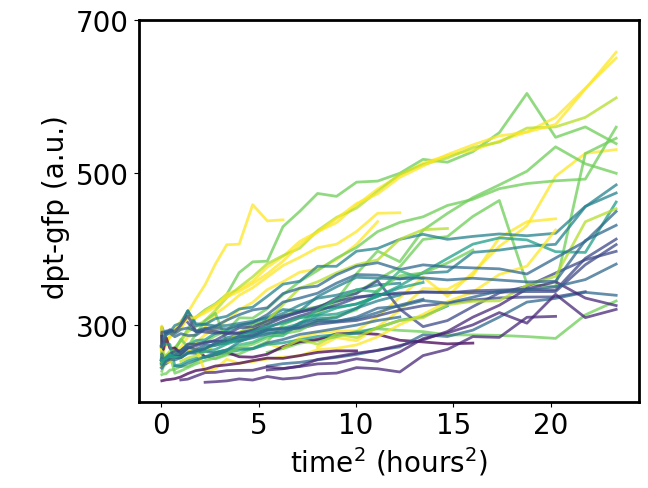

In [194]:
# plot individual traces colored by slope
plt.figure()
fontsize = 20
cell_ids = np.unique(df.cell_id)
bkg = 300
slope_arr = np.zeros(len(cell_ids))
start_time_arr = np.zeros(len(cell_ids))
num_colors = 10
colors = plt.cm.viridis(np.linspace(0, 1, num_colors))
slope_color_arr = np.linspace(0, 15, num_colors)
for i, id in enumerate(cell_ids):
    sub_df = df[df.cell_id==id]
    sub_df = sub_df.sort_values(by='t')
    inten = sub_df.dpt_gfp
    inten = inten - bkg
    inten[inten < 0] = 0
    if len(inten) < 3:
        continue
    t_arr = sub_df.t.values
    #slope, offset = fit_trace(np.sqrt(inten), t_arr / 6)
    slope, offset = fit_trace(inten, (t_arr / 6) ** 2)
    greater_than_zero_ids = np.where(inten > 0)[0]
    if len(greater_than_zero_ids) == 0:
        start_time_arr[i] = 0
    else:
        start_time_arr[i] = t_arr[greater_than_zero_ids[0]]
        
    #start_time_arr[i] = -offset / slope
    slope_arr[i] = slope
    if np.isnan(slope):
        continue
    this_color = colors[np.abs(slope - slope_color_arr) == np.min(np.abs(slope - slope_color_arr))]
    plt.plot((t_arr / 6) ** 2, sub_df.dpt_gfp, linewidth=2, color=this_color, alpha=0.75)

slope_arr = slope_arr[slope_arr > 0]
start_time_arr = start_time_arr[start_time_arr > 0]

plt.ylim([200, 700])
plt.xlabel('time$^2$ (hours$^2$)', fontsize=fontsize)
plt.ylabel('\n dpt-gfp (a.u.)', fontsize=fontsize)
#plt.xticks([0, 2, 4])
plt.yticks([300, 500, 700])
#plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/traces_and_mean_trace_vs_t2_colored_by_slope.pdf')


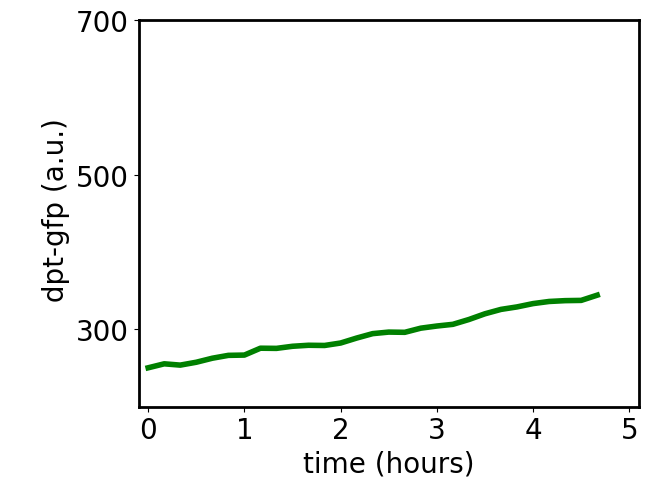

In [487]:
# plot single traces
id = 21
plt.figure()
fontsize = 20
cell_ids = np.unique(df.cell_id)
bkg = 0.01
sub_df = df[df.cell_id==id]
sub_df = sub_df.sort_values(by='t')
inten = sub_df.dpt_gfp
inten = inten - bkg
inten[inten < 0] = 0
plt.plot((sub_df.t / 6), inten, linewidth=4, color='g')

plt.ylim([200, 700])
plt.xlim([-0.1, 5.1])
plt.xlabel('time (hours)', fontsize=fontsize)
plt.ylabel('\n dpt-gfp (a.u.)', fontsize=fontsize)
#plt.xticks([0, 2, 4])
plt.yticks([300, 500, 700])
#plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/example_trace_id_21.pdf')

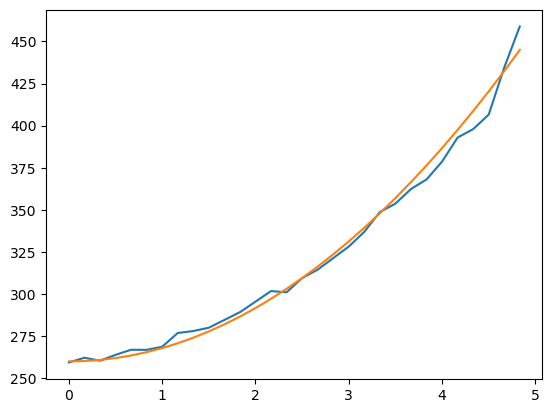

In [228]:
mean = df.groupby('t').mean().dpt_gfp
plt.figure()
plt.plot(np.unique(df.t) / 6, mean.values)
plt.plot(np.unique(df.t) / 6, 0.22 * 36 * np.unique(df.t / 6) ** 2 + 260)
#plt.plot(np.unique(df.t) / 6, )

In [ ]:
plt.figure()
t_arr = np.unique(df.t)
for t in t_arr:
    sub_df = df[df.cell_id==id]
    sub_df = sub_df.sort_values(by='t')
    inten = sub_df.dpt_gfp
    inten = inten - bkg
    inten[inten < 0] = 0
    plt.plot(sub_df.t / 6, inten)
    #plt.plot(sub_df.t, sub_df.dpt_gfp)

plt.yscale('linear')

In [137]:
%matplotlib inline

/tmp/ipykernel_1596274/3333436819.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


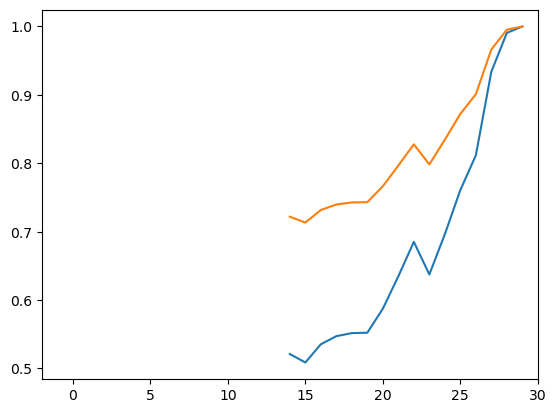

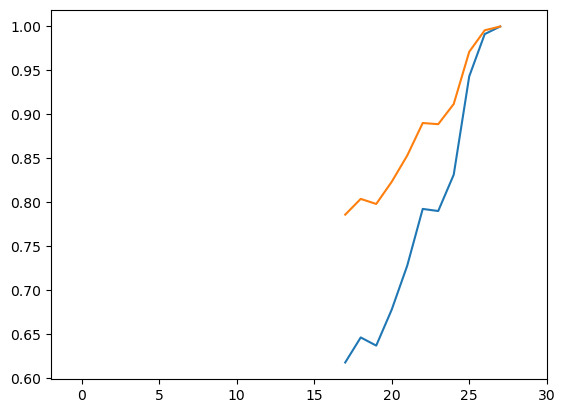

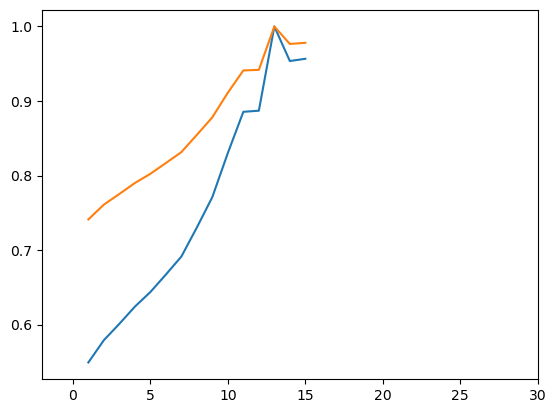

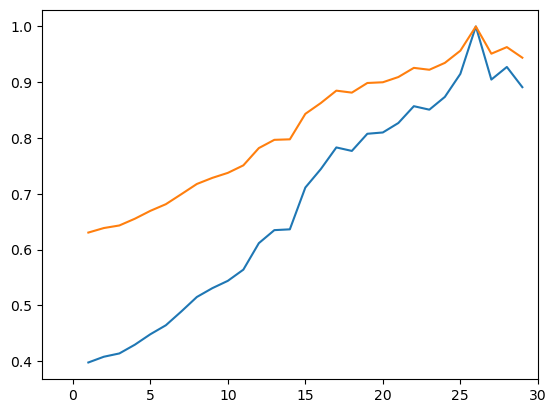

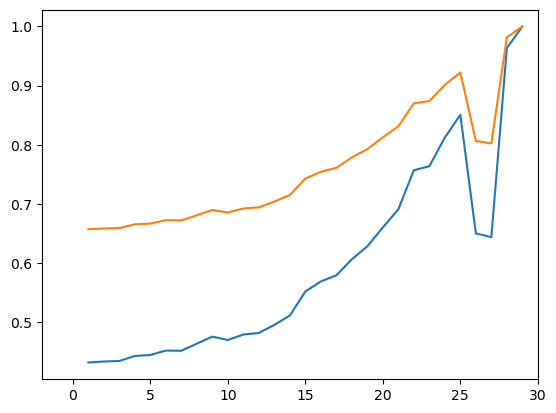

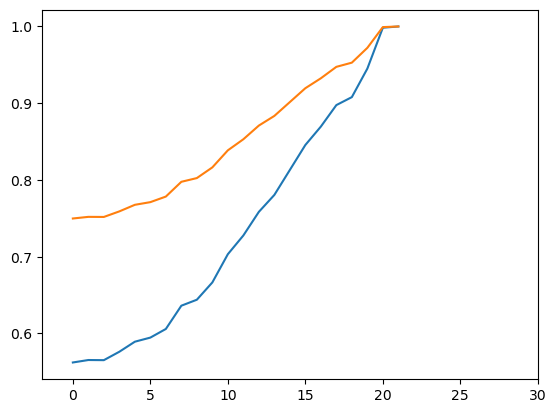

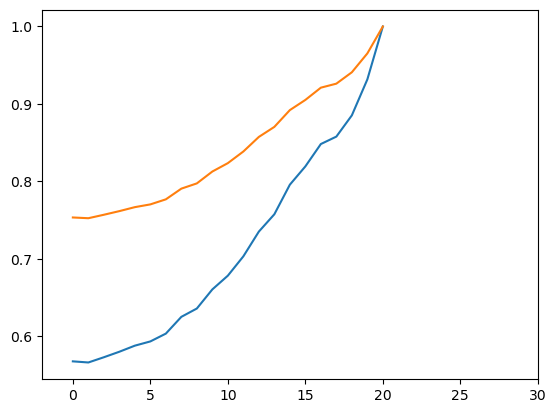

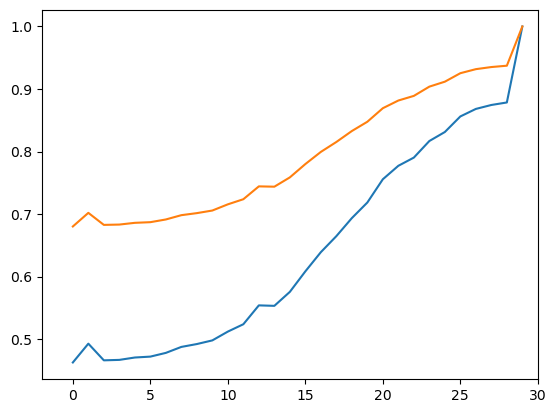

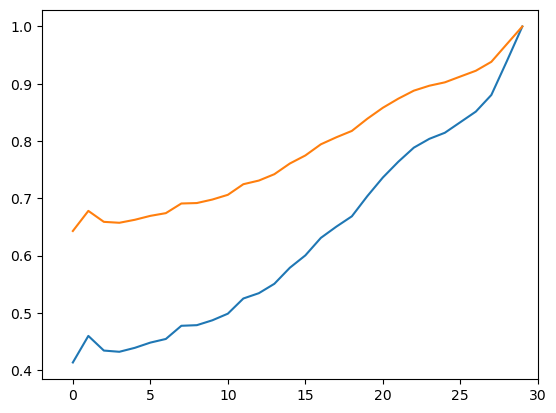

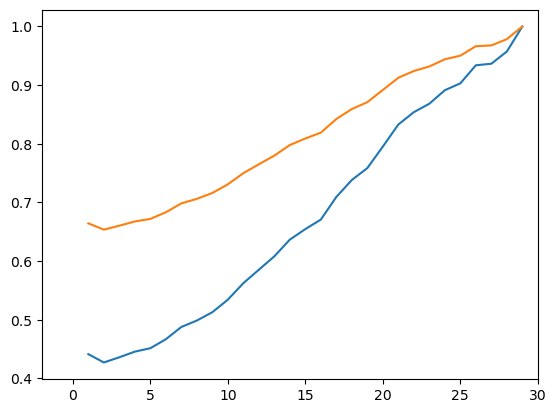

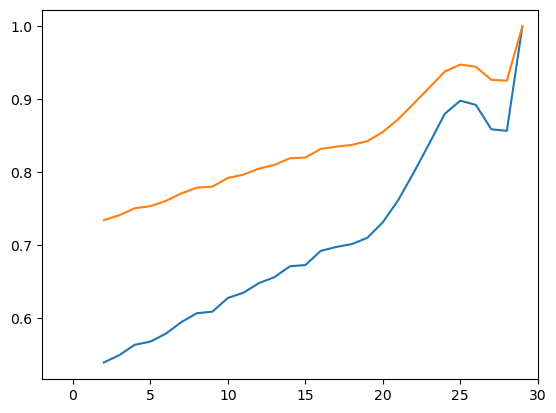

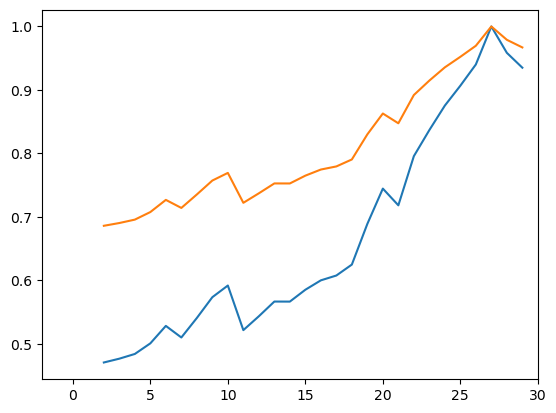

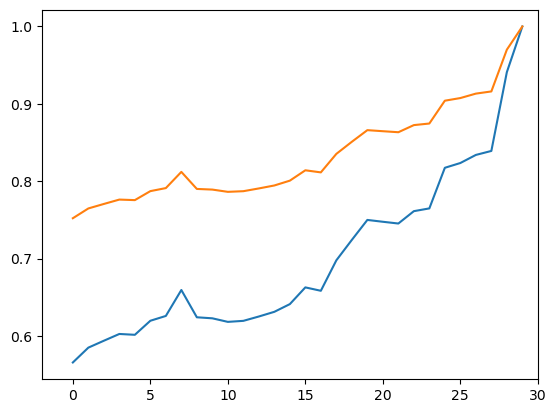

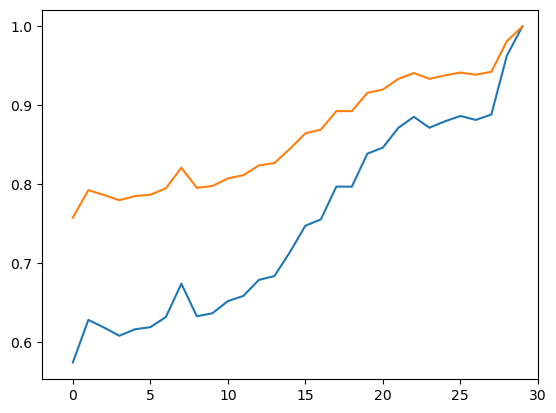

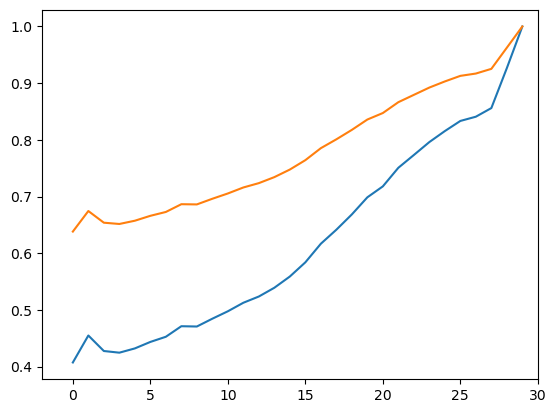

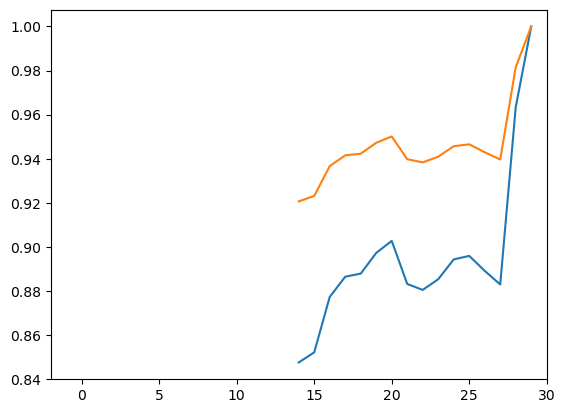

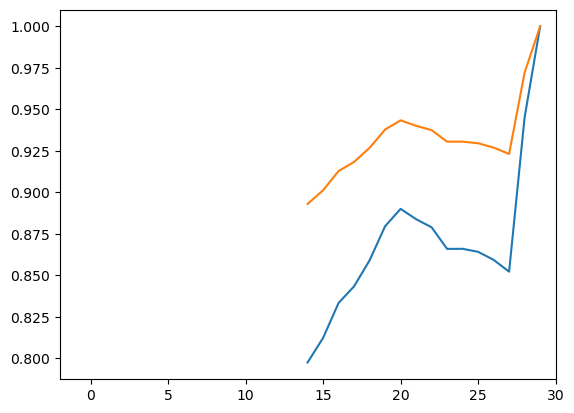

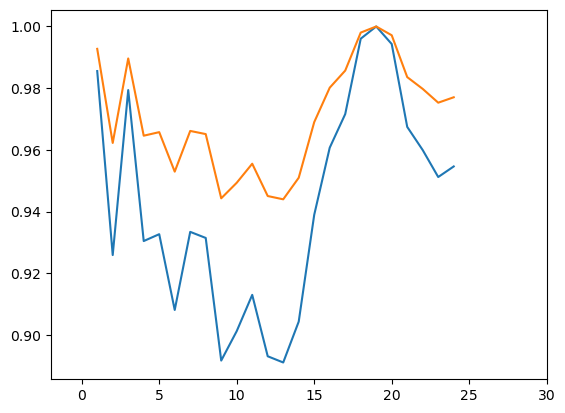

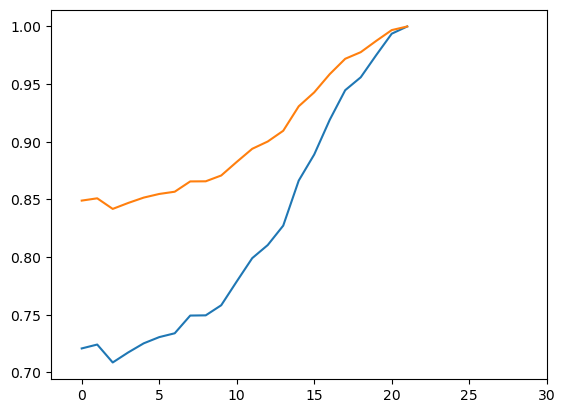

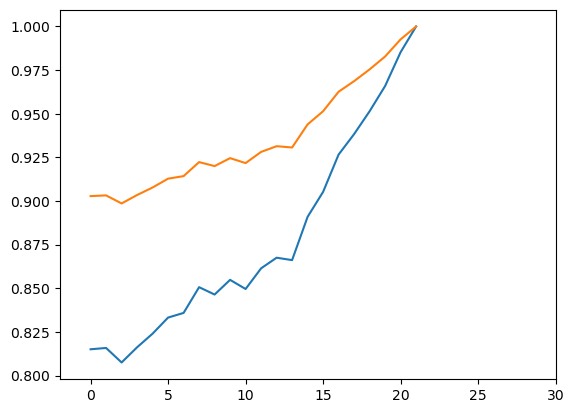

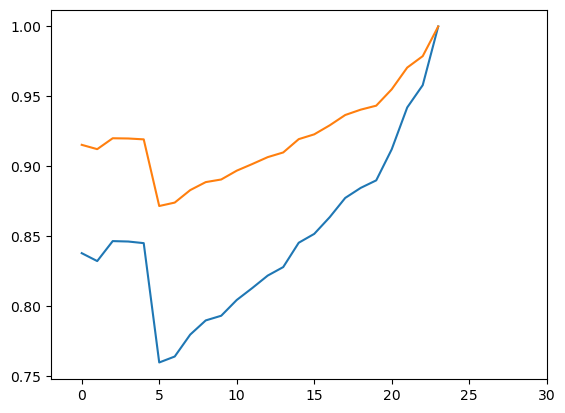

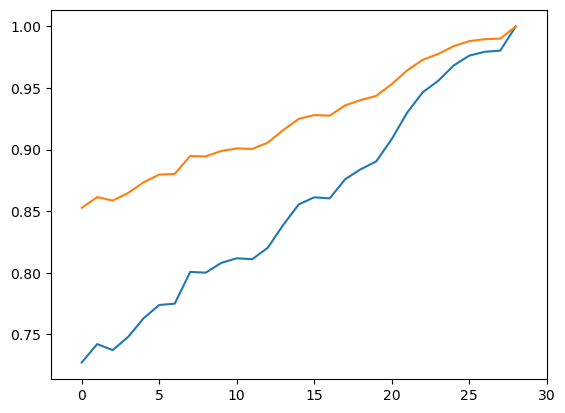

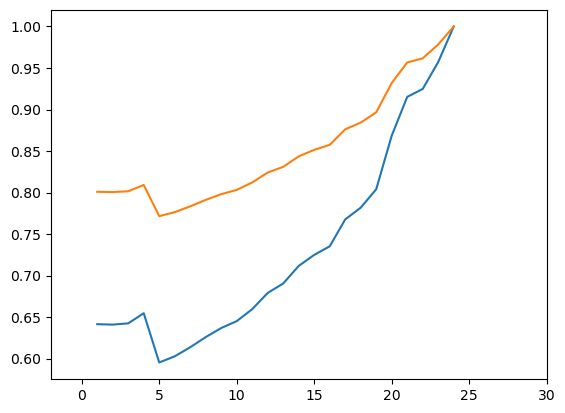

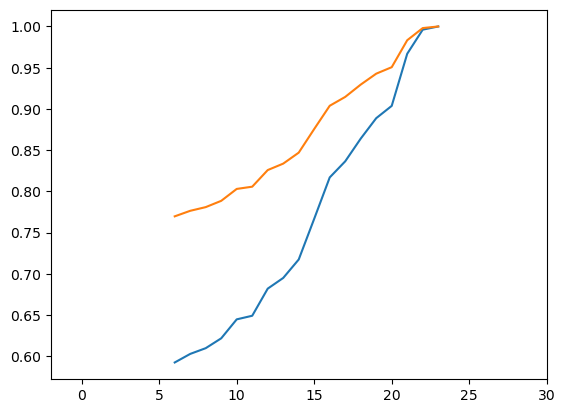

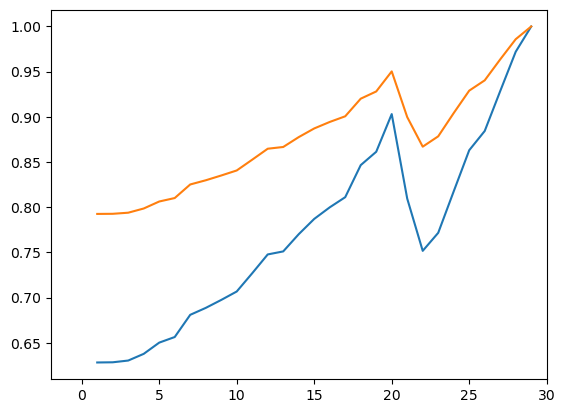

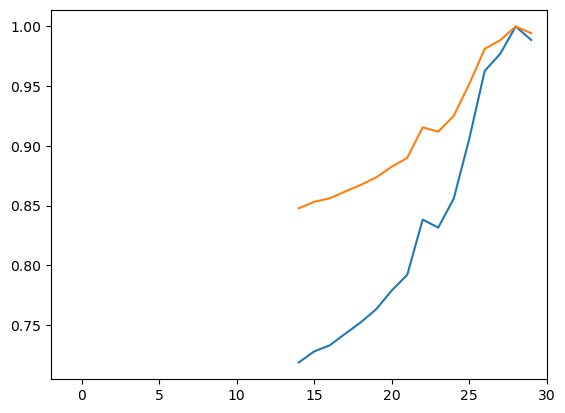

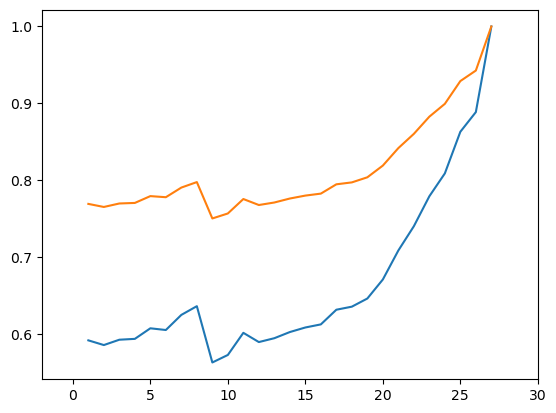

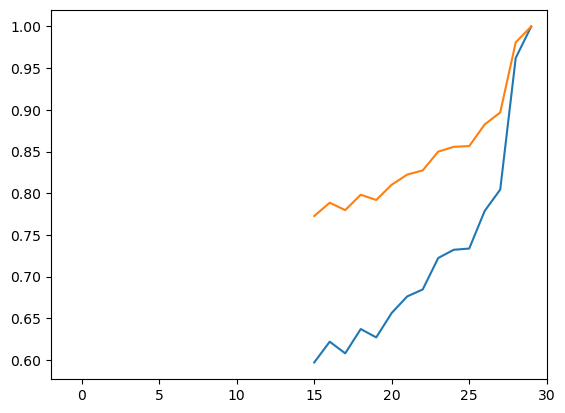

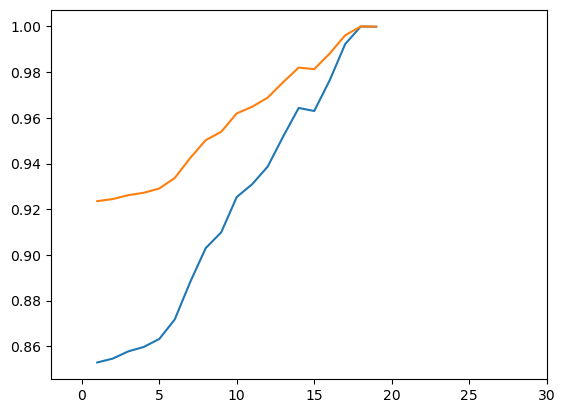

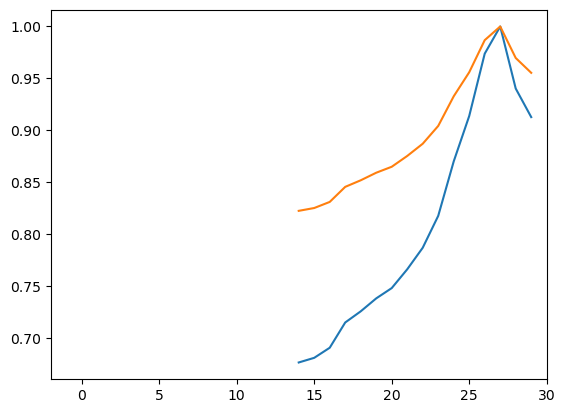

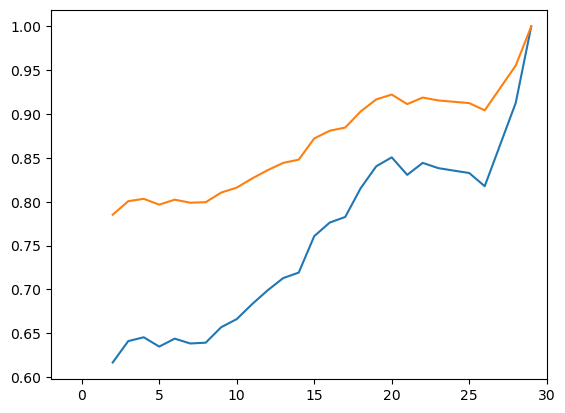

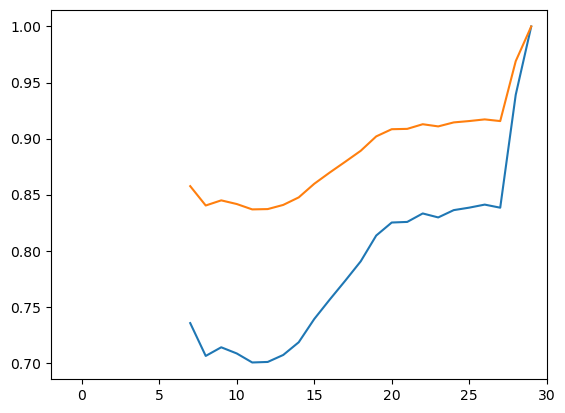

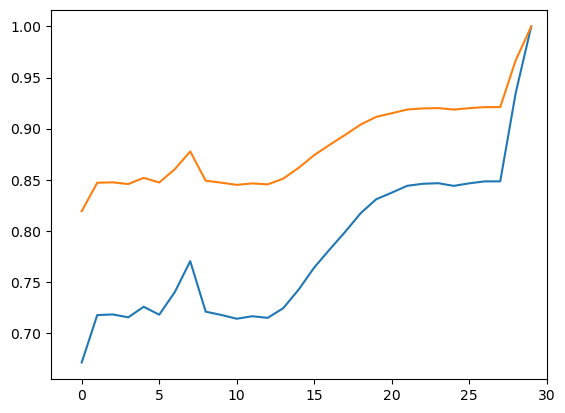

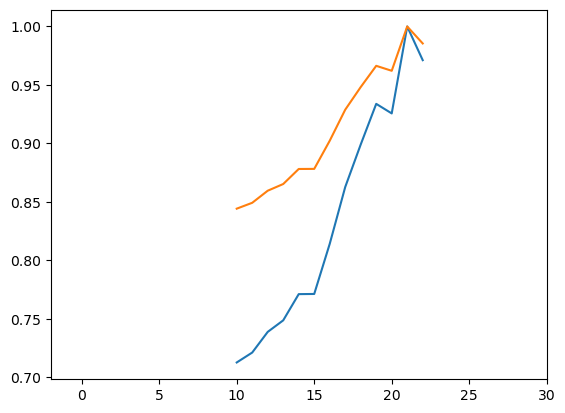

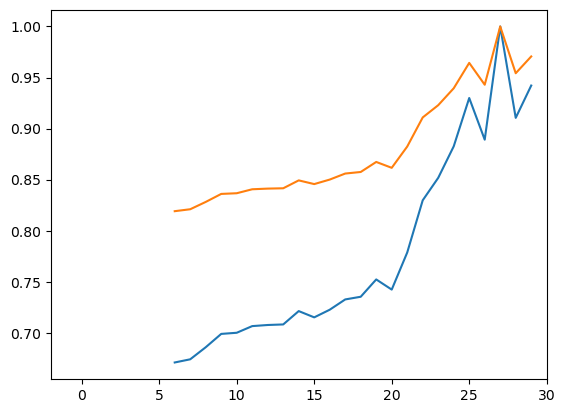

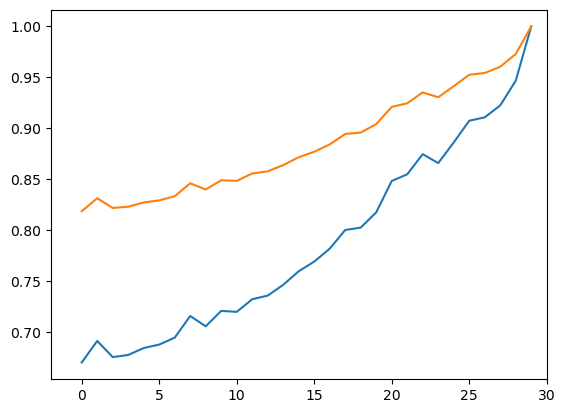

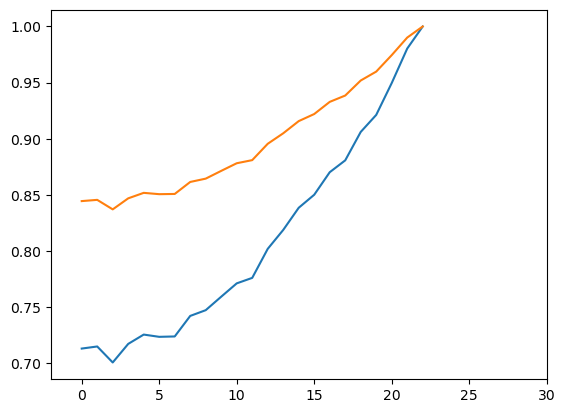

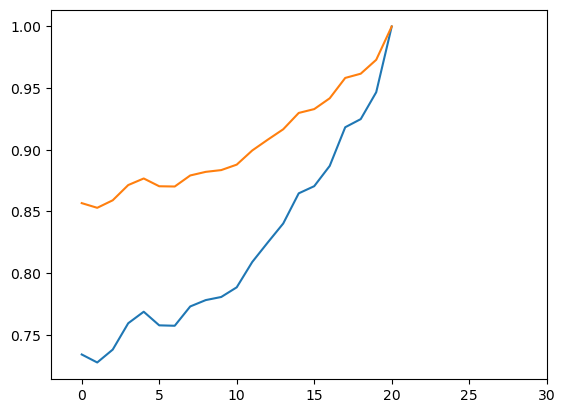

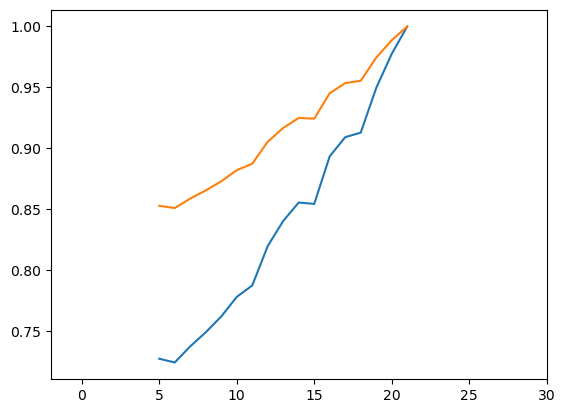

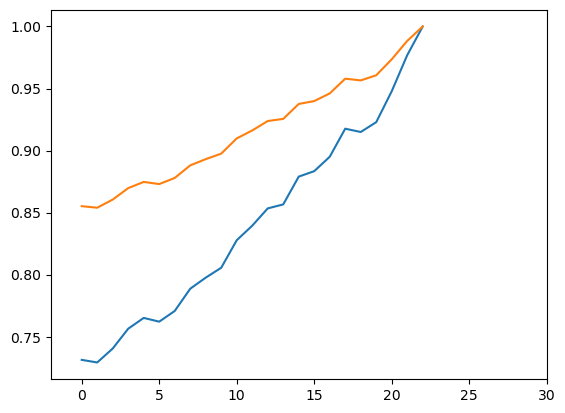

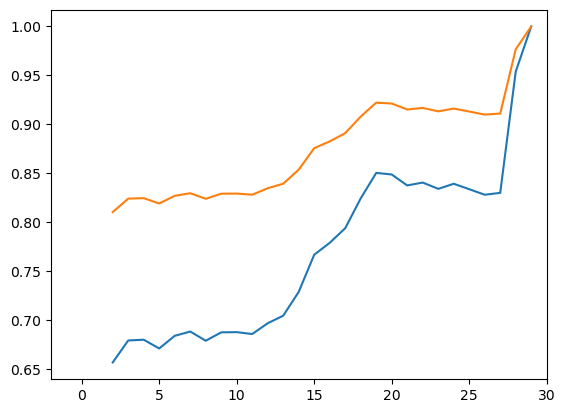

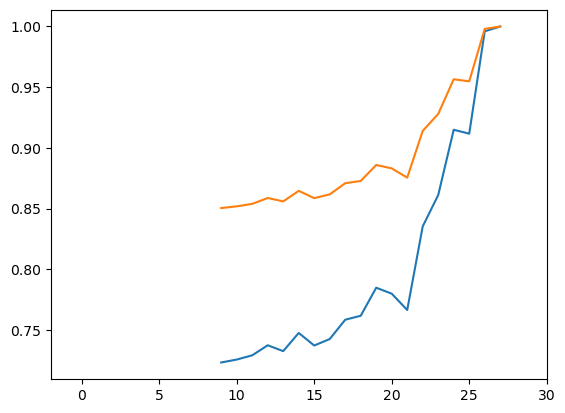

In [206]:
cell_ids = np.unique(df.cell_id)
bkg = 0.01
for id in cell_ids:
    plt.figure()
    sub_df = df[df.cell_id==id]
    sub_df = sub_df.sort_values(by='t')
    inten = sub_df.dpt_gfp.values.astype('float64')
    inten = inten - bkg
    inten[inten < 0] = 0
    plt.plot(sub_df.t, inten / np.max(inten))
    plt.plot(sub_df.t, np.sqrt(inten) / np.max(np.sqrt(inten)))

    #plt.plot(sub_df.t, sub_df.dpt_gfp)
    plt.xlim([-2, 30])
    #plt.ylim([200, 700])

plt.yscale('linear')

In [92]:
I = inten.values
np.where(I > 0)[0][0]

15

In [57]:
df.to_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_03_07-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_modified_earlyL3_timeseries/larvae_2/manual_analysis/all_cells.pkl')

In [63]:
this_mip = mips[int(df.iloc[0].t)]

In [64]:
plt.figure()
plt.imshow(this_mip, vmax=500)

In [87]:
plt.figure()
plt.hist(df[df.t > 24].dpt_gfp)

(array([10., 31., 19., 19., 11., 10.,  8., 13.,  4.,  2.]),
 array([0.00965933, 0.01103465, 0.01240997, 0.01378529, 0.01516061,
        0.01653593, 0.01791125, 0.01928657, 0.02066189, 0.02203721,
        0.02341253]),
 <BarContainer object of 10 artists>)

In [70]:
plt.hist(df[df.t <=5].dpt_gfp)

(array([ 5.,  6., 12., 43., 31., 15., 10., 10., 17.,  9.]),
 array([0.00809697, 0.008355  , 0.00861303, 0.00887106, 0.00912908,
        0.00938711, 0.00964514, 0.00990317, 0.0101612 , 0.01041922,
        0.01067725]),
 <BarContainer object of 10 artists>)

In [24]:
cell_ids = np.unique(df.cell_id)
bkg = 300
slope_arr = np.zeros(len(cell_ids))
start_time_arr = np.zeros(len(cell_ids))
for i, id in enumerate(cell_ids):
    sub_df = df[df.cell_id==id]
    sub_df = sub_df.sort_values(by='t')
    inten = sub_df.dpt_gfp
    inten = inten - bkg
    inten[inten < 0] = 0
    if len(inten) < 3:
        continue
    t_arr = sub_df.t.values
    #slope, offset = fit_trace(np.sqrt(inten), t_arr / 6)
    slope, offset = fit_trace(inten, (t_arr / 6) ** 2)
    greater_than_zero_ids = np.where(inten > 0)[0]
    if len(greater_than_zero_ids) == 0:
        start_time_arr[i] = 0
    else:
        start_time_arr[i] = t_arr[greater_than_zero_ids[0]]
        
    #start_time_arr[i] = -offset / slope
    slope_arr[i] = slope

slope_arr = slope_arr[slope_arr > 0]
start_time_arr = start_time_arr[start_time_arr > 0]

/tmp/ipykernel_459265/974677170.py:52: RuntimeWarning: invalid value encountered in double_scalars
  slope = np.sum((x - mx) * (y - my)) / np.sum((x - mx) ** 2)


In [22]:
x = np.array([0,0,1, 2])
len(np.where(x < 0)[0])

0

In [331]:
print(np.mean(slope_arr ** 2))
print(np.std(slope_arr ** 2))

27.787264676543764
26.138431487007285


In [332]:
print(np.mean(start_time_arr ** 2))
print(np.std(start_time_arr ** 2))

4.3441353940936835
4.2581329432522415


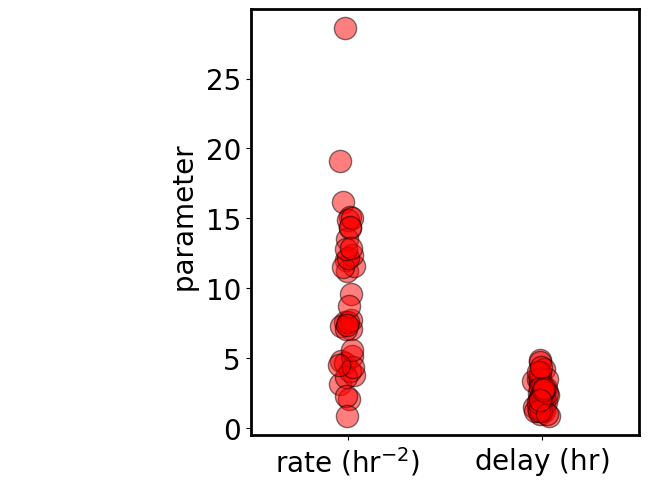

In [27]:
# scatter plot of slope and delay
plt.figure()
fontsize = 20


sigma_x = 0.02
plt.plot(np.ones(len(slope_arr)) + sigma_x * np.random.normal(size=len(slope_arr)), slope_arr, 'ko',
        markerfacecolor='r', markersize=16, alpha=0.5)
plt.plot(1 + np.ones(len(start_time_arr)) + sigma_x * np.random.normal(size=len(start_time_arr)), 
         start_time_arr / 6, 'ko', markerfacecolor='r', markersize=16, alpha=0.5)

plt.xticks([1, 2], labels=['rate (hr$^{-2}$)', 'delay (hr$^{}$)'], fontsize=fontsize)
plt.xlim([0.5, 2.5])
plt.ylabel('\n \n \n \n \n parameter', fontsize=fontsize)
#plt.yscale('log')
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/timeseries_param_dists.pdf')


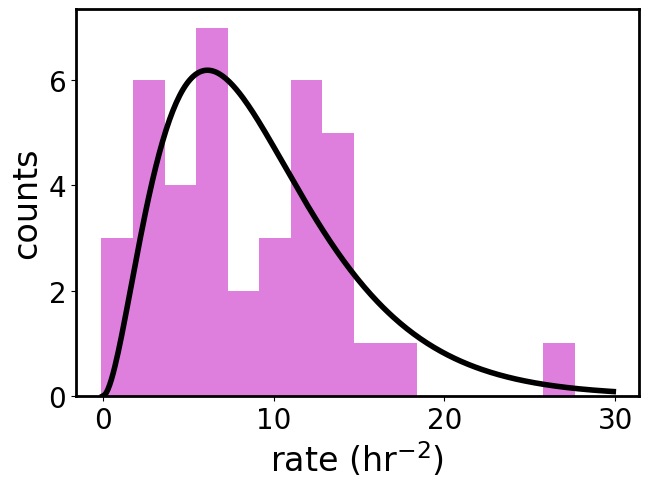

In [422]:
counts, bins = np.histogram(slope_arr, bins=15)
mean_slope = np.mean(slope_arr)
std_slope = np.std(slope_arr)
k = mean_slope ** 2 / std_slope ** 2
theta = std_slope ** 2 / mean_slope
x = np.linspace(0, 30, 300+1)
dx = np.diff(x)
x = x[:-1]
y = x ** (k - 1) * np.exp(-x / theta)
norm = np.sum(np.diff(bins)*counts)
pred_counts = (y / np.sum(y) / dx) * norm

plt.figure()
#plt.plot(bins[:-1], counts, 'mo', markersize=12)
plt.bar(bins[:-1], counts, width=bins[1] - bins[0], facecolor='m', alpha=0.5, edgecolor=None)
plt.plot(x, pred_counts, 'k-', linewidth=4)
plt.xlabel('rate (hr$^{-2}$)', fontsize=24)
plt.ylabel('counts', fontsize=24)

ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/slope_histogram_fine_bins.pdf')


In [246]:
mean_slope

9.386145104101534

(array([121., 255., 231., 185., 102.,  56.,  28.,  12.,   6.,   4.]),
 array([ 0.36634306,  3.552359  ,  6.73837493,  9.92439086, 13.11040679,
        16.29642272, 19.48243865, 22.66845458, 25.85447051, 29.04048645,
        32.22650238]),
 <BarContainer object of 10 artists>)

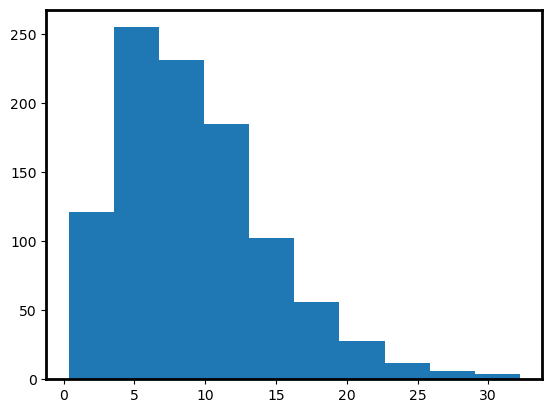

In [119]:
slopes = np.random.gamma(shape=k, scale=theta, size=1000)
plt.hist(slopes)


(array([7., 3., 5., 4., 5., 5., 5., 2., 2., 2.]),
 array([0.83333333, 1.23333333, 1.63333333, 2.03333333, 2.43333333,
        2.83333333, 3.23333333, 3.63333333, 4.03333333, 4.43333333,
        4.83333333]),
 <BarContainer object of 10 artists>)

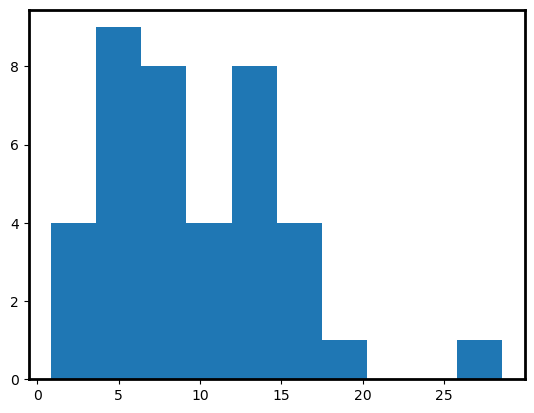

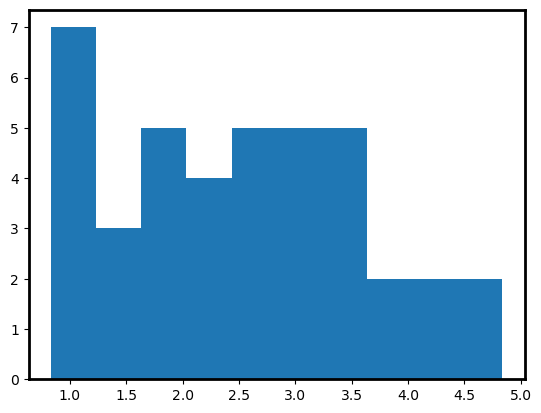

In [108]:
plt.figure()
plt.hist(slope_arr, bins=10)

plt.figure()
plt.hist(start_time_arr / 6, bins=10)

In [32]:
print(f'{np.mean(slope_arr)}, {np.std(slope_arr)}')
print(f'{np.mean(start_time_arr)}, {np.std(start_time_arr)}')

9.386145104101534, 5.533396396472157
15.175, 6.464856920303805


In [81]:
def simulate_traces(n_traces, t_max, dt, mean_slope, std_slope, mean_delay, std_delay, initial_inten=300):
    #slopes = np.random.normal(loc=mean_slope, scale=std_slope, size=n_traces)
    #slopes[slopes < 0] = 0
    k = mean_slope ** 2 / std_slope ** 2
    theta = std_slope ** 2 / mean_slope
    slopes = np.random.gamma(shape=k, scale=theta, size=n_traces)
    
    #delays = np.random.normal(loc=mean_delay, scale=std_delay, size=n_traces)
    #delays[delays < 0] = 0
    if mean_delay > 0:
        k = mean_delay ** 2 / std_delay ** 2
        theta = std_delay ** 2 / mean_delay
        delays = np.random.gamma(shape=k, scale=theta, size=n_traces)
    else:
        delays = np.zeros(n_traces)
    
    num_time_points = int(np.floor(t_max / dt))
    t_arr = np.arange(0, int(t_max), dt)
    #intens = initial_inten * np.ones((num_time_points, int(n_traces)))
    intens = np.random.lognormal(mean=np.log(300), sigma=0.4, size=(num_time_points, int(n_traces)))
    for i in range(1, num_time_points):
        #intens[i] = intens[i - 1] + dt * (slopes) * (t_arr[i] > delays)
        intens[i] = intens[i - 1] + dt * 2 * t_arr[i-1] * (slopes) * (t_arr[i] > delays)


    return intens, t_arr
        

In [82]:
intens, t_arr = simulate_traces(100000, t_max=24, dt=1/6, mean_slope=9.4, std_slope=5.5, mean_delay=0 *15/6, std_delay=6.5/6)

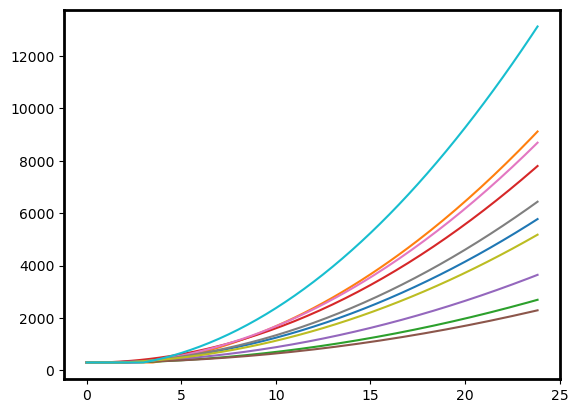

In [46]:
plt.figure()
plt.plot(t_arr, intens[:,:10])

In [304]:
df = pd.read_pickle(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/df_mod_eL3_24.pkl')
ids = np.array([4, 1, 5, 7, 2, 3, 6]) - 1
shifts = [700, 1300, 430, 450, 580, 1200, 580]
df['bkg'] = 0
for i in range(len(df)):
    this_id = ids[df.iloc[i].experiment_id]
    df.at[df.index[i], 'bkg'] = shifts[this_id]
data_intens = df.dpt_gfp - (df.bkg - 300)
num_bins = 20
bins = np.logspace(2.3, 5, num_bins+1)
counts, _bins = np.histogram(data_intens, bins)
bin_widths = np.diff(bins)
bins_data = bins[:-1]
prob_dens_data = counts / np.sum(counts) / bin_widths


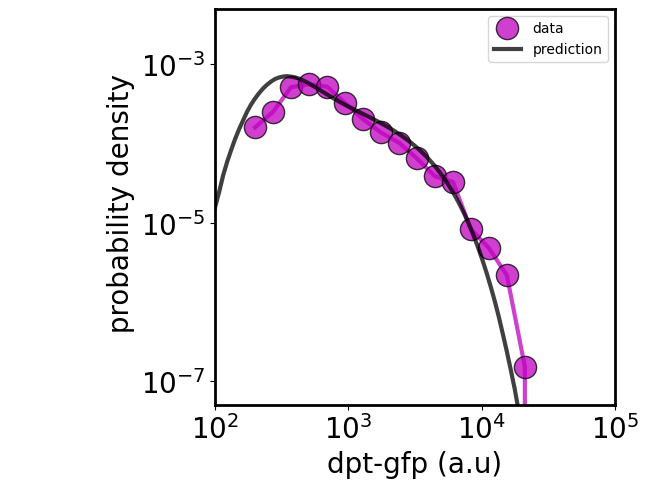

In [193]:
plt.figure()
plt.plot(bins_data, prob_dens_data, 'm-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins_data, prob_dens_data, 'ko', markersize=16, markerfacecolor='m', label='data', alpha=0.75)

num_bins = 100
bins = np.logspace(2, 5, num_bins+1)

counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
plt.plot(bins, prob_dens, '-', linewidth=3, color='k', label='prediction', alpha=0.75)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xticks([1e2, 1e3, 1e4, 1e5], fontsize=fontsize)
plt.xlabel('dpt-gfp (a.u)', fontsize=fontsize)
plt.ylabel('\n \n \n probability density', fontsize=fontsize)
plt.yticks([1e-7, 1e-5, 1e-3])
plt.ylim([5e-8, 5e-3])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/24hr_dist_and_prediction.pdf')


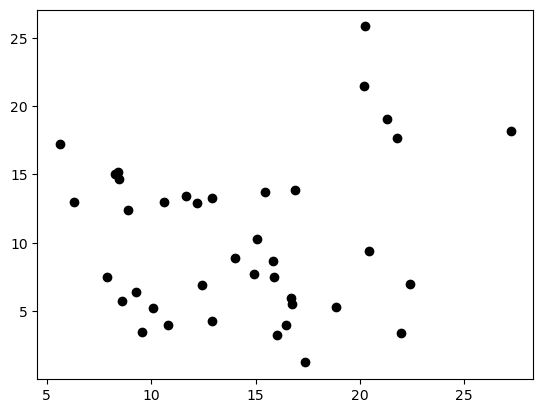

In [201]:
plt.figure()
plt.plot(start_time_arr, slope_arr, 'ko')

In [230]:
np.cumsum(intens[:,0] * 1/6)

array([   50.        ,   100.        ,   150.        ,   200.        ,
         250.        ,   300.        ,   350.        ,   400.        ,
         450.        ,   500.        ,   550.        ,   600.        ,
         650.        ,   701.64853591,   754.94560772,   809.89121545,
         866.48535908,   924.72803862,   984.61925407,  1046.15900542,
        1109.34729269,  1174.18411586,  1240.66947494,  1308.80336993,
        1378.58580082,  1450.01676763,  1523.09627034,  1597.82430896,
        1674.20088349,  1752.22599392,  1831.89964027,  1913.22182252,
        1996.19254068,  2080.81179475,  2167.07958472,  2254.99591061,
        2344.5607724 ,  2435.7741701 ,  2528.63610371,  2623.14657322,
        2719.30557865,  2817.11311998,  2916.56919722,  3017.67381037,
        3120.42695942,  3224.82864439,  3330.87886526,  3438.57762204,
        3547.92491473,  3658.92074332,  3771.56510783,  3885.85800824,
        4001.79944456,  4119.38941679,  4238.62792492,  4359.51496897,
      

In [298]:
intens = np.random.lognormal(mean=np.log(300), sigma=0.9, size=1000)
plt.figure()
plt.hist(np.log10(intens))

(array([  6.,  15.,  71., 147., 220., 225., 183.,  82.,  42.,   9.]),
 array([1.25150489, 1.48680985, 1.7221148 , 1.95741976, 2.19272471,
        2.42802967, 2.66333462, 2.89863957, 3.13394453, 3.36924948,
        3.60455444]),
 <BarContainer object of 10 artists>)

In [295]:
np.log(300)

5.703782474656201

In [297]:
np.log(500/200)

0.9162907318741551

# Cartoons of deterministic vs stochastic models

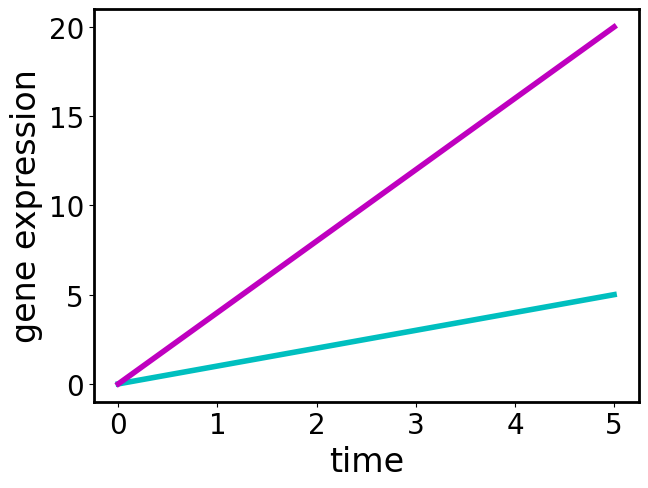

In [210]:
# determinisitc

t_arr = np.linspace(0, 5, 100)
x1 = t_arr
x2 = 4 * t_arr
plt.figure()
plt.plot(t_arr, x1, 'c-', linewidth=4)
plt.plot(t_arr, x2, 'm-', linewidth=4)
plt.xlabel('time', fontsize=24)
plt.ylabel('gene expression', fontsize=24)

ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/deterministic_example.pdf')


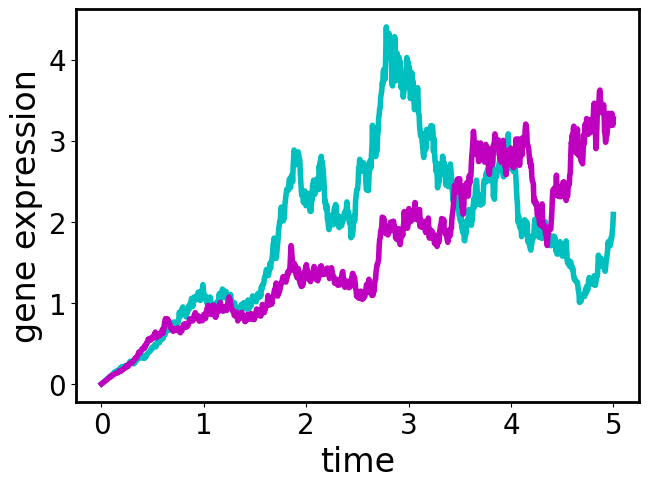

In [215]:
# stochastic

t_arr = np.linspace(0, 5, 1000)
dt = t_arr[1] - t_arr[0]
num_steps = len(t_arr)
sigma = 0.5
x1 = np.zeros_like(t_arr)
x2 = np.zeros_like(t_arr)
dW = np.sqrt(dt) * np.random.normal(scale=sigma, size=(2, num_steps))
rate = 1
for i in range(1, num_steps):
    x1[i] = x1[i-1] + dt * rate + x1[i-1] * dW[0, i]
    if x1[i] < 0:
        x1[i] = 0
    x2[i] = x2[i-1] + dt * rate + x2[i-1] * dW[1, i]
    if x2[i] < 0:
        x2[i] = 0

plt.figure()
plt.plot(t_arr, x1, 'c-', linewidth=4)
plt.plot(t_arr, x2, 'm-', linewidth=4)
plt.xlabel('time', fontsize=24)
plt.ylabel('gene expression', fontsize=24)

ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/stochastic_example.pdf')


# Fit multiplicative noise model to 24 hour dist

In [284]:
def simulate_stochastic_model(num_cells, Tmax, dt, rate, sigma, A0=None):
    t_arr = np.arange(0, Tmax, dt)
    num_steps = len(t_arr)
    m = np.zeros((num_steps, num_cells))
    A = np.zeros_like(m)
    if A0 is not None:
        #m[0] = A0
        A[0] = A0
    
    dW = np.sqrt(dt) * np.random.normal(scale=sigma, size=(num_steps, num_cells))
    for i in range(1, num_steps):
        new_m = m[i-1] + dt * 2 * rate + m[i-1] * dW[i-1]
        new_m[new_m < 0] = 0
        m[i] = new_m
        A[i] = A[i-1] + dt * m[i-1]
    
    return A, m, t_arr

In [458]:
num_cells = 10000
Tmax = 24
dt = 0.01
rate = 3
sigma = 0.5
A0 = np.random.lognormal(mean=np.log(250), sigma=0.1, size=num_cells)
A, m, t_arr = simulate_stochastic_model(num_cells, Tmax, dt, rate, sigma, A0=A0)

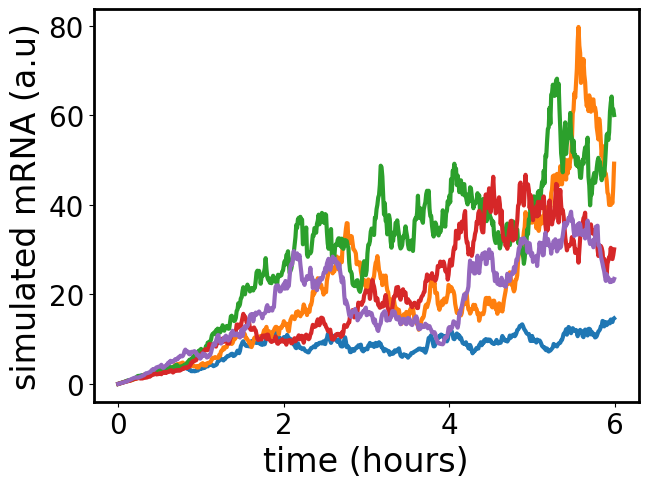

In [456]:
# examples of stochastic model
plt.figure()
plt.plot(t_arr, m[:,:5], linewidth=3)
plt.xlabel('time (hours)', fontsize=24)
plt.ylabel('simulated mRNA (a.u)', fontsize=24)

ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/stochastic_model_mrna_traces.pdf')

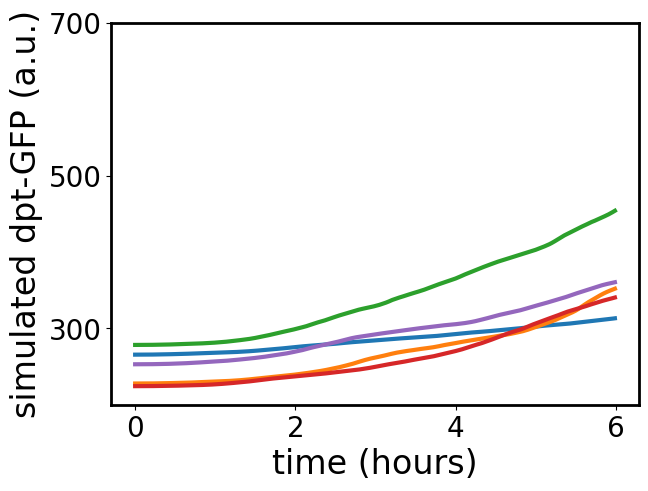

In [457]:
plt.figure()
plt.plot(t_arr, A[:,:5], linewidth=3)
plt.xlabel('time (hours)', fontsize=24)
plt.ylabel('simulated dpt-GFP (a.u.)', fontsize=24)
plt.ylim([200, 700])
plt.yticks([300, 500, 700])

ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/stochastic_model_dpt-gfp_traces.pdf')

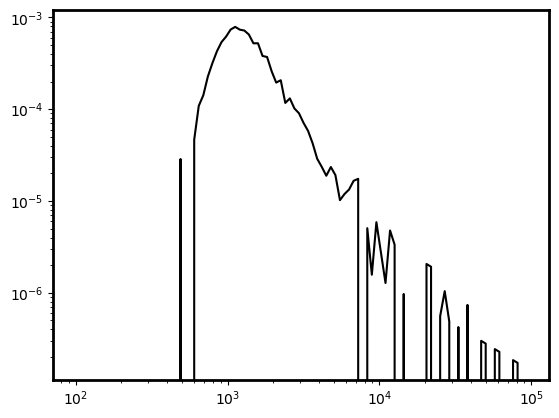

In [331]:
plt.figure()
num_bins = 100
bins = np.logspace(2, 5, num_bins + 1)
counts, _ = np.histogram(A[-1], bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
bins = bins[:-1]
plt.plot(bins, prob_dens, 'k-')
plt.yscale('log')
plt.xscale('log')

In [459]:
# fit simulated traces to deterministic model
noise_slopes = np.zeros(A.shape[1])
for i in range(A.shape[1]):
    this_inten = A[:,i]
    slope, offset = fit_trace(this_inten, t_arr ** 2)
    noise_slopes[i] = slope

    

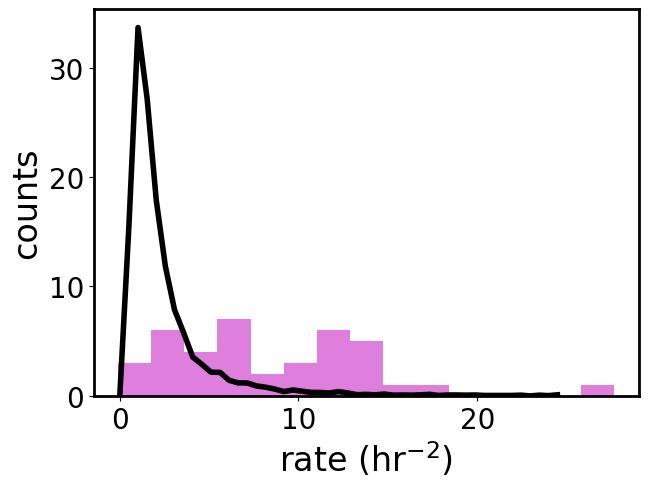

In [460]:
counts, bins = np.histogram(slope_arr, bins=15)
norm = np.sum(np.diff(bins)*counts)

pred_bins = np.linspace(0, 25, 50)
pred_counts, _ = np.histogram(noise_slopes, pred_bins)
pred_counts = (pred_counts / np.sum(pred_counts) / (pred_bins[1] - pred_bins[0])) * norm

plt.figure()
#plt.plot(bins[:-1], counts, 'mo', markersize=12)
plt.bar(bins[:-1], counts, width=bins[1] - bins[0], facecolor='m', alpha=0.5, edgecolor=None)
plt.plot(pred_bins[:-1], pred_counts, 'k-', linewidth=4)
plt.xlabel('rate (hr$^{-2}$)', fontsize=24)
plt.ylabel('counts', fontsize=24)

ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/slope_histogram_stochastic_fit.pdf')

In [426]:
np.sum(pred_counts * (pred_bins[1] - pred_bins[0]))

72.12933798897171

In [421]:
pred_bins = np.linspace(0, 25, 50)
pred_counts, _ = np.histogram(noise_slopes, pred_bins)
pred_counts = (pred_counts / np.sum(pred_counts) / (pred_bins[1] - pred_bins[0]))
np.sum(pred_counts * (pred_bins[1] - pred_bins[0]))

1.0

In [316]:
# grid search
num_cells = 1000
Tmax = 24
dt = 0.01
num_rates = 20
num_sigmas = 21
rates = np.linspace(1, 24, num_rates)
sigmas = np.linspace(0.05, 2.5, num_sigmas)
mean_lA = np.zeros((num_rates, num_sigmas))
std_lA = np.zeros((num_rates, num_sigmas))
A0 = np.random.lognormal(mean=np.log(300), sigma=0.4, size=num_cells)

for i in range(num_rates):
    print(f'{i} of {num_rates}')
    for j in range(num_sigmas):
        A, m, t_arr = simulate_stochastic_model(num_cells, Tmax, dt, rate=rates[i], sigma=sigmas[j], A0=A0)
        mean_lA[i, j] = np.nanmean(np.log10(A[-1]))
        std_lA[i, j] = np.nanstd(np.log10(A[-1]))




0 of 20
1 of 20
2 of 20
3 of 20
4 of 20
5 of 20
6 of 20
7 of 20
8 of 20
9 of 20
10 of 20
11 of 20
12 of 20
13 of 20
14 of 20
15 of 20
16 of 20
17 of 20
18 of 20
19 of 20


In [307]:
mean_lData = np.nanmean(np.log10(data_intens.astype('float32')))
std_lData = np.nanstd(np.log10(data_intens.astype('float32')))

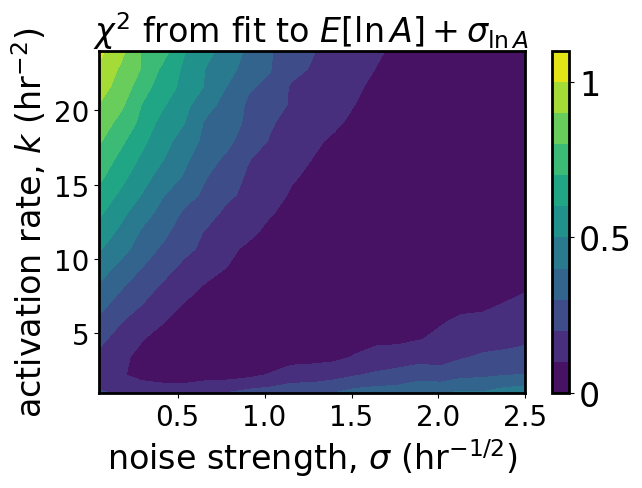

In [384]:
# chi2
chi2 = (mean_lA - mean_lData) ** 2 + (std_lA - std_lData) ** 2
plt.figure()
plt.contourf(sigmas, rates, chi2, levels=10)
plt.xlabel('noise strength, $\sigma$ (hr$^{-1/2}$)', fontsize=24)
plt.ylabel('activation rate, $k$ (hr$^{-2}$)', fontsize=24)
#plt.title('fit to $\langle \ln A \rangle$ + $\sigma_{\ln A}$, $\chi^2$', fontsize=24)
plt.title('$\chi^2$ from fit to $E[\ln A] + \sigma_{\ln A}$ ', fontsize=24)
cbar = plt.colorbar()
cbar.ax.set_yticks([0, 0.5, 1])
cbar.ax.set_yticklabels(labels=[0, 0.5, 1],fontsize=24)
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/chi2_fit.pdf')

In [338]:
row, col = np.where(chi2==np.min(chi2))
print(rates[row])
print(sigmas[col])

[8.26315789]
[1.52]


## plot data distributions with stochastic model fit

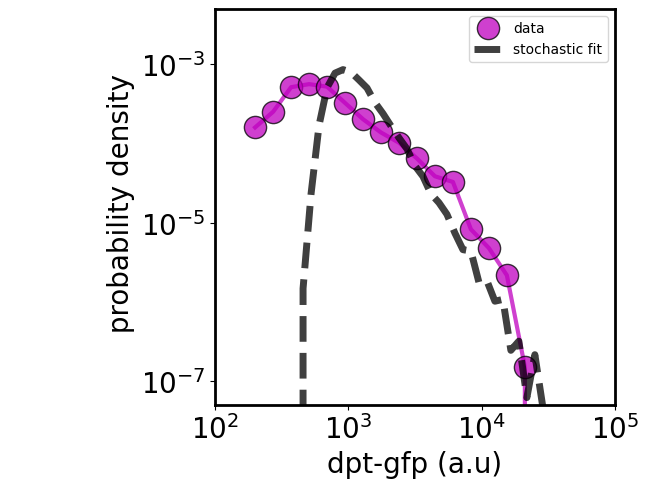

In [446]:
plt.figure()

# data
plt.plot(bins_data, prob_dens_data, 'm-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins_data, prob_dens_data, 'ko', markersize=16, markerfacecolor='m', label='data', alpha=0.75)

# stochastic model
num_cells = 10000
Tmax = 24
dt = 0.01
rate = 3
sigma = 0.5
A0 = np.random.lognormal(mean=np.log(250), sigma=0.1, size=num_cells)
A, m, t_arr = simulate_stochastic_model(num_cells, Tmax, dt, rate, sigma, A0=A0)
intens = A[-1]
num_bins = 50
bins = np.logspace(2, 5, num_bins+1)
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
plt.plot(bins, prob_dens, '--', linewidth=5, color='k', label='stochastic fit', alpha=0.75)

# # deterministic model
# intens, _ = simulate_traces(100000, t_max=24, dt=1/6, mean_slope=9.4, std_slope=5.5, mean_delay=0 *15/6, std_delay=6.5/6)
# num_bins = 50
# bins = np.logspace(2, 5, num_bins+1)
# counts, _bins = np.histogram(intens, bins)
# bin_widths = np.diff(bins)
# bins = bins[:-1]
# prob_dens = counts / np.sum(counts) / bin_widths
# plt.plot(bins, prob_dens, '-', linewidth=3, color='k', label='deterministic', alpha=0.75)

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xticks([1e2, 1e3, 1e4, 1e5], fontsize=fontsize)
plt.xlabel('dpt-gfp (a.u)', fontsize=fontsize)
plt.ylabel('\n \n \n probability density', fontsize=fontsize)
plt.yticks([1e-7, 1e-5, 1e-3])
plt.ylim([5e-8, 5e-3])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/24hr_dist_and_stochastic_prediction.pdf')


In [347]:
np.std(np.log10(intens))

0.3245913332948401

In [348]:
std_lData

0.4378936